# Toxic Comment Classification Challenge
### Identify and classify toxic online comments

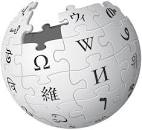

short summary of the challange:

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

    toxic
    severe_toxic
    obscene
    threat
    insult
    identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.

For full data and challange descrtiption see: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

RESULT WAS 98.7% accuracy
;-)  ETA: 0s - loss: 0.0452 - acc: 0.9876 ;-)

In [0]:
#imports
import os
from IPython.display import display

import pandas as pd
import numpy as np
# plot the graph 
import matplotlib.pyplot as plt 
# used for plot interactive graph
import seaborn as sns 
from wordcloud import WordCloud ,STOPWORDS
#nlp
import string
#for regex
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

#KERAS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import warnings
warnings.filterwarnings('ignore')


In [48]:
# download the zip with data's
! wget https://github.com/figolino/ToxicCommet/raw/master/sample_submission.csv.zip
! wget https://github.com/figolino/ToxicCommet/raw/master/train.csv.zip
! wget https://github.com/figolino/ToxicCommet/raw/master/test.csv.zip
! wget https://github.com/figolino/ToxicCommet/raw/master/test_labels.csv.zip

# unzip and load data's
! unzip /content/train.csv.zip;
! unzip /content/sample_submission.csv.zip;
! unzip /content/test.csv.zip;
! unzip /content/test_labels.csv.zip;

#split the data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
subm = pd.read_csv('/content/sample_submission.csv')


--2019-12-16 14:28:25--  https://github.com/figolino/ToxicCommet/raw/master/sample_submission.csv.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/figolino/ToxicCommet/master/sample_submission.csv.zip [following]
--2019-12-16 14:28:25--  https://raw.githubusercontent.com/figolino/ToxicCommet/master/sample_submission.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1459715 (1.4M) [application/zip]
Saving to: ‘sample_submission.csv.zip’

sample_submission.c 100%[===================>]   1.39M  --.-KB/s    in 0.07s   

2019-12-16 14:28:25 (19.4 MB/s) - ‘sample_submission.csv.zip’ saved [1459715

# Data exploration
Exploration to understand what is in a dataset and the characteristics of the data.

In [50]:
# Now lets have a look at the datas....
display(train.head())

# Shape of data i.e. rows and columns
display(print('\n Number of attributes in the dataset: ', train.shape))

# let's see if we need to clean up some data's ;-)
display(train.info())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



 Number of attributes in the dataset:  (159571, 8)


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


None

In [51]:
# same for Test 
# Now lets have a look at the datas....
display(test.head())

# Shape of data i.e. rows and columns
display(print('\n Number of attributes in the dataset: ', test.shape))

# let's see if we need to clean up some data's ;-)
display(test.info())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.



 Number of attributes in the dataset:  (153164, 2)


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


None

In [52]:
# desc
display(train.describe())
display(test.describe())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,id,comment_text
count,153164,153164
unique,153164,153164
top,168c0d2bc4239f97,""" \n\n == Lead Incorrect == \n\n Nanosolar's w..."
freq,1,1


Looks like we don't need to deal with the null values after all ;-) Cool

* There are a few empty comments we will fill it
* Create a 'none' label so we can see how many comments have no labels (are clean / not toxic)
* Let's check the length of the comments....

In [53]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
display(train.describe())

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


394.0732213246768

590.7202819048923

5000

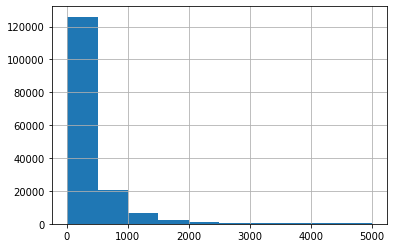

In [54]:
lens = train.comment_text.str.len()
display(lens.mean(), lens.std(), lens.max())
display(lens.hist())

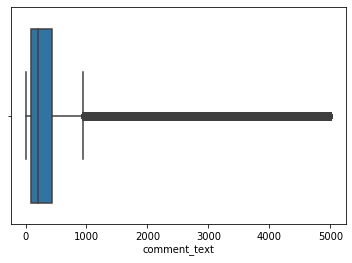

In [55]:
# and boxplot as well
display(sns.boxplot(lens))

The length of the comments varies a lot. but the most are arraound 400


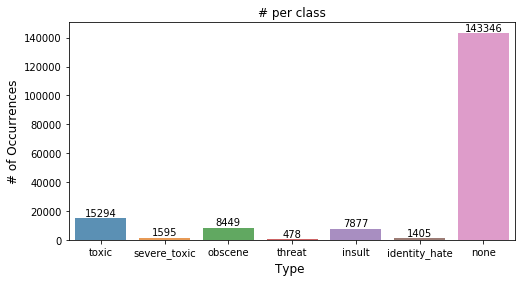

In [56]:
# so let's plot some datas ;-) 
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
*   May we have multiple tags associated with each comment (eg) a comment can be classified as both toxic and obscene.

Letz's check this as a next step...


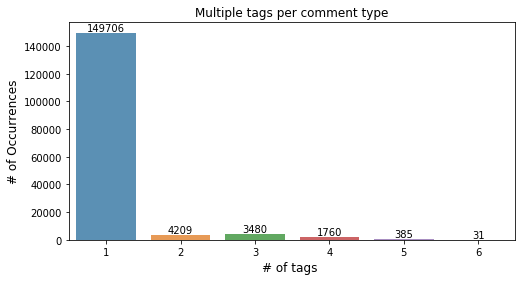

In [57]:
rowsums=train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment type")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Exploring Correlations

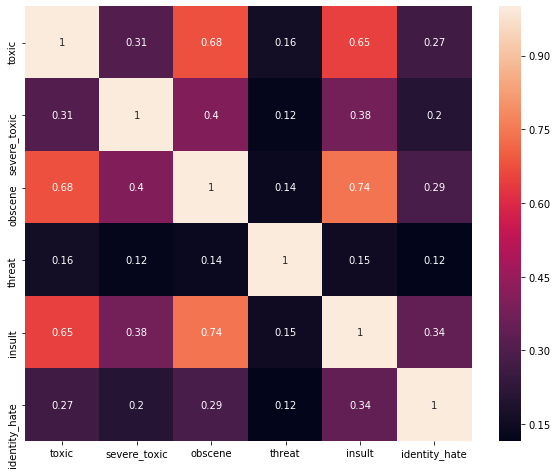

In [58]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

A moderate positive correlation of 0.74 exists between obscene comments and insult. This means that if user comment are toxyc it's obscene with insult, :-(
and with 0.68 if its toxic it's allmost obscene!

To find a pattern between two categorical variables we can use Confusion matrix/Crosstab.

In [59]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

out


severe_toxic       obscene        ...  insult       identity_hate      
severe_toxic            0     1       0     1  ...       0     1             0     1
toxic                                          ...                                  
0                  144277     0  143754   523  ...  143744   533        144174   103
1                   13699  1595    7368  7926  ...    7950  7344         13992  1302

[2 rows x 10 columns]

The above table represents the consufion matix of Toxic comments with the other classes.

Some interesting observations:

*    A Severe toxic comment is always toxic
*    Other classes seem to be a subset of toxic barring a few exceptions


Example Comments


In [60]:
print("toxic:")
print(train[train.toxic==1].iloc[1,1])
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[1,1])
print("Threat:")
print(train[train.threat==1].iloc[1,1])
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])
print("identity_hate:")
print(train[train.identity_hate==1].iloc[1,1])

toxic:
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
severe_toxic:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms
Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead

Wordclouds - Frequent words
Now, let's take a look at words that are associated with these classes.

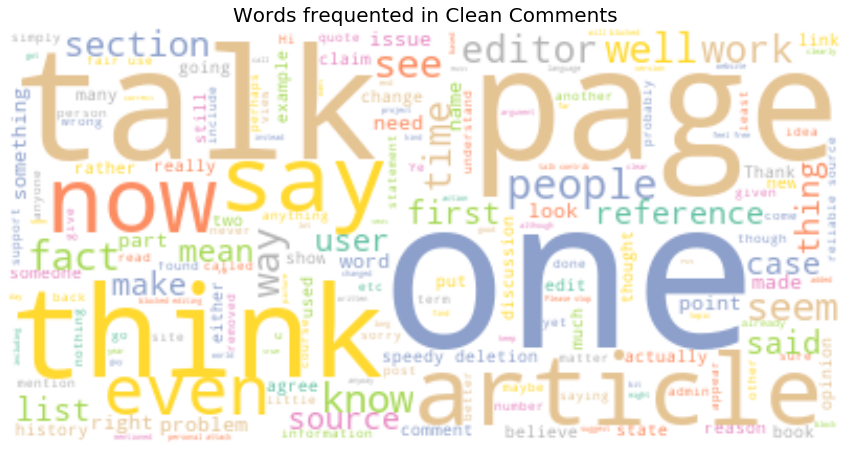

In [61]:
stopword=set(STOPWORDS)
subset=train[train.none==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=1000,stopwords=stopword, colormap="Set2")
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

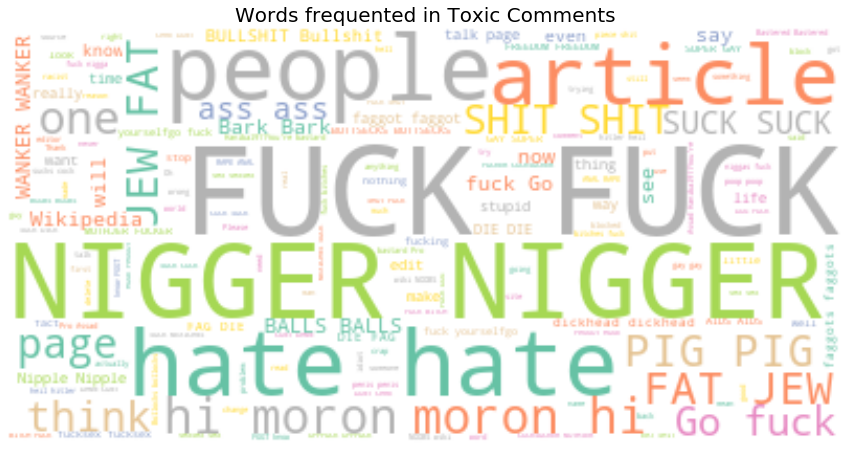

In [62]:
stopword=set(STOPWORDS)
subset=train[train.toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=1000,stopwords=stopword, colormap="Set2")
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

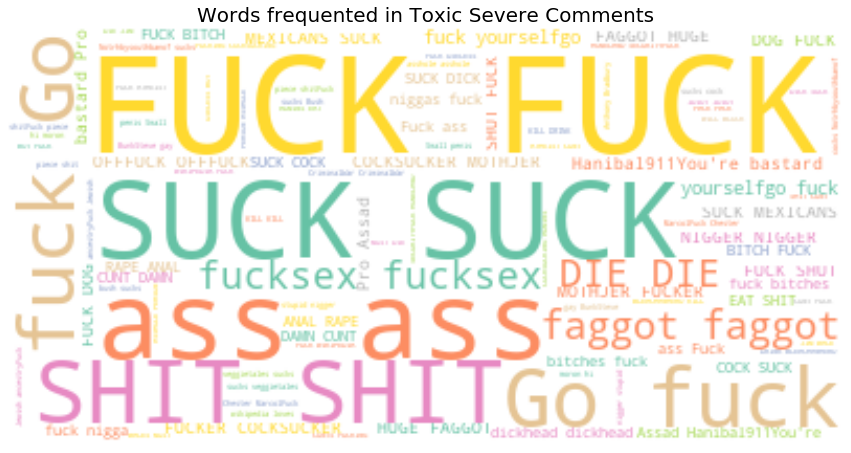

In [63]:
stopword=set(STOPWORDS)
subset=train[train.severe_toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=1000,stopwords=stopword, colormap="Set2")
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Words frequented in Toxic Severe Comments", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

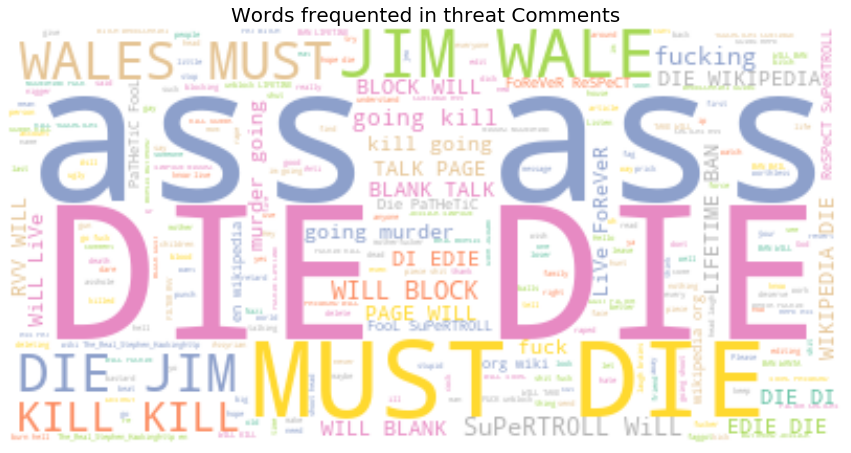

In [64]:
stopword=set(STOPWORDS)
subset=train[train.threat==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=1000,stopwords=stopword, colormap="Set2")
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Words frequented in threat Comments", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

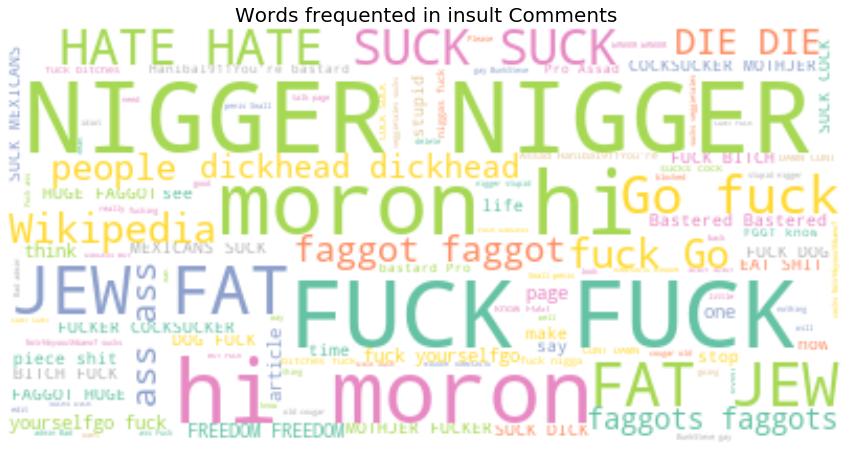

In [65]:
stopword=set(STOPWORDS)
subset=train[train.insult==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=1000,stopwords=stopword, colormap="Set2")
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.show()

# Deep Learing Model

*  Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture


The dependent variables are in the training set itself so we need to split them up, into X and Y sets.

In [66]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]
display(list_sentences_train.describe())
display(list_sentences_test.describe())

count                                                159571
unique                                               159571
top       "  The current picture is far too ""in your fa...
freq                                                      1
Name: comment_text, dtype: object

count                                                153164
unique                                               153164
top       " \n\n == Lead Incorrect == \n\n Nanosolar's w...
freq                                                      1
Name: comment_text, dtype: object

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:
* Tokenization - We need to break down the sentence into unique words.
* Indexing - We put the words in a dictionary-like structure and give them an index each.
* Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM.

In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences.


In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Since some comments are terribly long, while some are just 1 word,
this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 400. ( abrox to the mean 394...)

In [0]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Finally the start of building our model! ;-)

This is the architecture of the model we are trying to build.

As mentioned earlier, the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 400. By indicating an empty space after comma, we are telling Keras to infer the number automatically.


In [0]:
inp = Input(shape=(maxlen, )) #maxlen=400 as defined earlier

In [0]:
# We need to define the size of the "vector space", and the number of unique words(max_features) we are using. The embedding size is a parameter that we can tune and experiment!!
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [0]:
# Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [0]:
#Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one.
x = GlobalMaxPool1D()(x)

In [0]:
#We set the dropout layer to drop out 10%(0.1) of the nodes.
x = Dropout(0.1)(x)

In [0]:
# we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:
#Activation( (Input X Weights) + Bias)
x = Dense(50, activation="relu")(x)

In [0]:
#We feed the output into a Dropout layer again.
x = Dropout(0.1)(x)

In [0]:
#Finally, we feed the output into a Sigmoid layer.
x = Dense(6, activation="sigmoid")(x)

In [0]:
#All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [78]:
# befor we start check the model Architecture is correct...
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0   

In [79]:
#  It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
   128/143613 [..............................] - ETA: 1:20:05 - loss: 0.6894 - acc: 0.6380

KeyboardInterrupt: ignored